In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from scipy.spatial.distance import cityblock
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
#from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

warnings.filterwarnings('ignore')

In [2]:
NO2=pd.read_csv("NO2_E43.csv", index_col = "DATETIME")
NO2.rename(columns = {'mg/m^3_43':'mg/m^3'}, inplace = True)
NO2

,mg/m^3
DATETIME,
2019-07-01 01:00:00,33.0
2019-07-01 02:00:00,27.0
2019-07-01 03:00:00,25.0
2019-07-01 04:00:00,34.0
2019-07-01 05:00:00,21.0
...,...
2022-06-30 20:00:00,76.0
2022-06-30 21:00:00,30.0
2022-06-30 22:00:00,20.0


In [3]:
NO2.describe()

,mg/m^3
count,24945.000000
mean,39.769854
std,21.679772
min,1.000000
25%,23.000000
50%,36.000000
75%,53.000000
max,157.000000


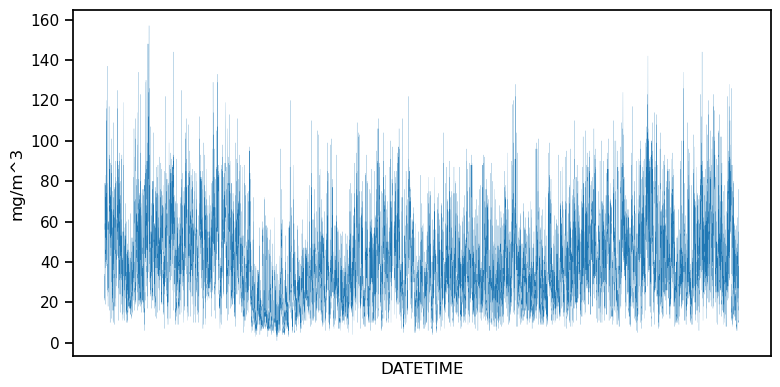

In [4]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=NO2["mg/m^3"],linewidth=.1)
plt.xticks(ticks=[])
plt.show()

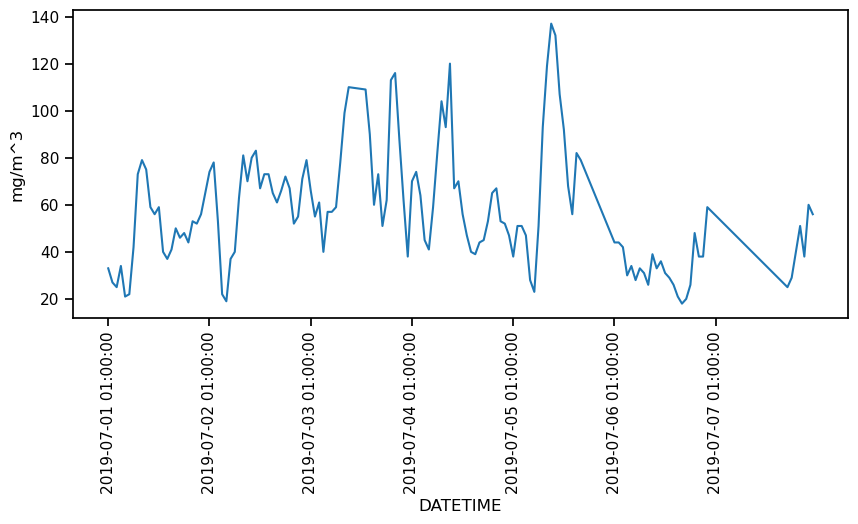

In [5]:
plt.figure(figsize=(10,4))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=NO2["mg/m^3"][:168])
plt.xticks(ticks=range(0,168,24), rotation=90)

plt.show()

## Missing values analysis

In [6]:
# % of missing values
1-NO2.count()/len(NO2)

mg/m^3    0.963276
dtype: float64

In [7]:
#NO2[ "mg/m^3_acum_NAN"]= 0

#for j in range(1,len(NO2)):

    #if NO2["mg/m^3"].isna()[j] == True :
        #NO2[ "mg/m^3_acum_NAN"][j] =   NO2[ "mg/m^3_acum_NAN"][j-1]+1   
        
        
    #else:
        #NO2[ "mg/m^3_acum_NAN"][j] = 0

In [8]:
#plt.figure(figsize=(9,4.5))
#sns.set_context("notebook")
#sns.axes_style("whitegrid")
#sns.lineplot(data=NO2["mg/m^3_acum_NAN"],linewidth=.1)
#plt.show()

In [9]:
#NO2[ "mg/m^3_peaks_acum_NAN"]= NO2[ "mg/m^3_acum_NAN"]


#for j in range(1,len(NO2)):

    #if (NO2["mg/m^3_acum_NAN"][j] == 0) or (NO2["mg/m^3_acum_NAN"][j+1] > 0) :
          
        #NO2[ "mg/m^3_peaks_acum_NAN"][j] = 0

In [10]:
#plt.figure(figsize=(9,4.5))
#sns.set_context("notebook")
#sns.axes_style("whitegrid")
#sns.lineplot(data=NO2["mg/m^3_peaks_acum_NAN"],linewidth=.1)
#plt.show()

In [11]:
#NO2["mg/m^3_peaks_acum_NAN"].value_counts().sort_index()

In [12]:
#plt.figure(figsize=(9,4.5))
#sns.set_context("notebook")
#sns.axes_style("whitegrid")
#sns.lineplot(data=NO2[:200]["mg/m^3_acum_NAN"],linewidth=.1)
#plt.show()

In [13]:
NO2["mg/m^3_im"] = NO2["mg/m^3"].fillna(NO2["mg/m^3"].mean())
NO2

,mg/m^3,mg/m^3_im
DATETIME,,
2019-07-01 01:00:00,33.0,33.0
2019-07-01 02:00:00,27.0,27.0
2019-07-01 03:00:00,25.0,25.0
2019-07-01 04:00:00,34.0,34.0
2019-07-01 05:00:00,21.0,21.0
...,...,...
2022-06-30 20:00:00,76.0,76.0
2022-06-30 21:00:00,30.0,30.0
2022-06-30 22:00:00,20.0,20.0


In [14]:
size = int(len(NO2["mg/m^3_im"])*.8)

train, test = NO2["mg/m^3_im"].iloc[:size], NO2["mg/m^3_im"].iloc[size:]

train.to_csv("NO2_E43_train.csv")
test.to_csv("NO2_E43_test.csv")

# 24 h mean analysis

In [15]:
NO2["mg/m^3_im_24h"] = np.nan

for j in range(23, len(NO2)):

    NO2[ "mg/m^3_im_24h"][j] = NO2["mg/m^3_im"][j-23:j+1].mean()
    
NO2

,mg/m^3,mg/m^3_im,mg/m^3_im_24h
DATETIME,,,
2019-07-01 01:00:00,33.0,33.0,NaN
2019-07-01 02:00:00,27.0,27.0,NaN
2019-07-01 03:00:00,25.0,25.0,NaN
2019-07-01 04:00:00,34.0,34.0,NaN
2019-07-01 05:00:00,21.0,21.0,NaN
...,...,...,...
2022-06-30 20:00:00,76.0,76.0,32.291667
2022-06-30 21:00:00,30.0,30.0,32.000000
2022-06-30 22:00:00,20.0,20.0,31.375000


In [16]:
NO2.head(48)

,mg/m^3,mg/m^3_im,mg/m^3_im_24h
DATETIME,,,
2019-07-01 01:00:00,33.0,33.0,NaN
2019-07-01 02:00:00,27.0,27.0,NaN
2019-07-01 03:00:00,25.0,25.0,NaN
2019-07-01 04:00:00,34.0,34.0,NaN
2019-07-01 05:00:00,21.0,21.0,NaN
2019-07-01 06:00:00,22.0,22.0,NaN
2019-07-01 07:00:00,42.0,42.0,NaN
2019-07-01 08:00:00,73.0,73.0,NaN
2019-07-01 09:00:00,79.0,79.0,NaN


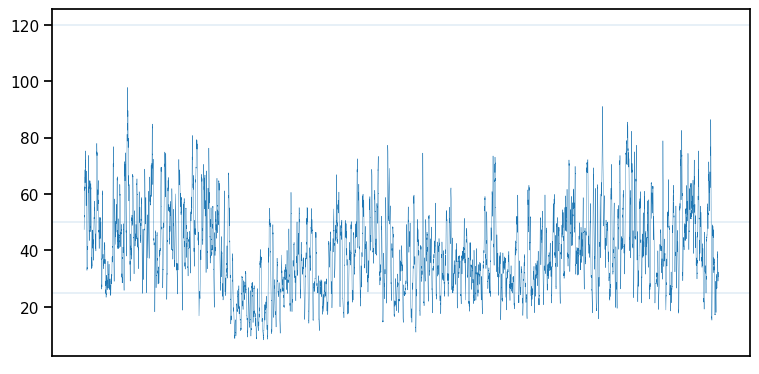

In [17]:
plt.figure(figsize=(9,4.5))
#sns.set_context("notebook")
#sns.axes_style("whitegrid")
#graph = sns.lineplot(data=NO2["mg/m^3_43_24h"],linewidth=.1)

plt.plot(NO2["mg/m^3_im_24h"],linewidth=.3)

#plt.gcf().autofmt_xdate()
plt.axhline(y=120,linewidth=.15)
plt.axhline(y=50,linewidth=.15)
plt.axhline(y=25,linewidth=.15)
plt.xticks(ticks=[])
#ax=plt.axes()
#ax.set_facecolor('white')

plt.show()

In [18]:
#NO2["AQG"] = np.nan
NO2["AQG"] = "NA"


for j in range(len(NO2)):
    if NO2[ "mg/m^3_im_24h"][j]<= 25:
        NO2["AQG"][j] = "+"
    elif 25<NO2[ "mg/m^3_im_24h"][j]<= 50:
        NO2["AQG"][j] = "I1"
    elif 50<NO2[ "mg/m^3_im_24h"][j]<= 120:
        NO2["AQG"][j] = "I2"
    elif NO2[ "mg/m^3_im_24h"][j]> 120:
        NO2["AQG"][j] = "-"    

    
    
NO2["AQG"].value_counts()

I1    15854
I2     6014
+      4005
NA       23
Name: AQG, dtype: int64

In [19]:
h1907_1910 = NO2[NO2.index<"2019-11"]["AQG"].value_counts()/len(NO2[NO2.index<"2019-11"]["AQG"])*100
h1911_2002 = NO2[("2019-10"< NO2.index)&(NO2.index<"2020-03")]["AQG"].value_counts()/len(NO2[("2019-10"< NO2.index)&(NO2.index<"2020-03")]["AQG"])*100

h2003_2006 = NO2[("2020-02"< NO2.index)&(NO2.index<"2020-07")]["AQG"].value_counts()/len(NO2[("2020-02"< NO2.index)&(NO2.index<"2020-07")]["AQG"])*100
h2007_2010 = NO2[("2020-06"< NO2.index)&(NO2.index<"2020-11")]["AQG"].value_counts()/len(NO2[("2020-06"< NO2.index)&(NO2.index<"2020-11")]["AQG"])*100
h2011_2102 = NO2[("2020-10"< NO2.index)&(NO2.index<"2021-03")]["AQG"].value_counts()/len(NO2[("2020-10"< NO2.index)&(NO2.index<"2021-03")]["AQG"])*100

h2103_2106 = NO2[("2021-02"< NO2.index)&(NO2.index<"2021-07")]["AQG"].value_counts()/len(NO2[("2021-02"< NO2.index)&(NO2.index<"2021-07")]["AQG"])*100
h2107_2110 = NO2[("2021-06"< NO2.index)&(NO2.index<"2021-11")]["AQG"].value_counts()/len(NO2[("2021-06"< NO2.index)&(NO2.index<"2021-11")]["AQG"])*100
h2111_2202 = NO2[("2021-10"< NO2.index)&(NO2.index<"2022-03")]["AQG"].value_counts()/len(NO2[("2021-10"< NO2.index)&(NO2.index<"2022-03")]["AQG"])*100

h2203_2206 = NO2[("2022-02"< NO2.index)]["AQG"].value_counts()/len(NO2[("2022-02"< NO2.index)]["AQG"])*100


In [20]:
data = {'24h1907-1910': h1907_1910,'24h1911-2002': h1911_2002,
        '24h2003-2006': h2003_2006,'24h2007-2010': h2007_2010,'24h2011-2102': h2011_2102,
        '24h2103-2106': h2103_2106,'24h2107-2110': h2107_2110,'24h2111-2202': h2111_2202,
        '24h2203-2206': h2203_2206       
       }
 
# Create DataFrame
per24h = pd.DataFrame(data)
 
# Print the output.
per24h

,24h1907-1910,24h1911-2001,24h2003-2006,24h2007-2010,24h2011-2102,24h2103-2106,24h2107-2110,24h2111-2202,24h2203-2206
+,1.200989,2.646396,43.239514,22.166667,17.431973,13.527778,12.990196,4.722222,8.358789
I1,57.294242,53.603604,44.481236,68.194444,65.164399,76.888889,70.043573,59.416667,57.622883
I2,40.692335,43.750000,12.279249,9.638889,17.403628,9.583333,16.966231,35.861111,34.018328
NA,0.812434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 24 h train forecasting

In [21]:
size = int(len(NO2["mg/m^3_im_24h"])*.8)

train_24, test_24 = NO2["mg/m^3_im_24h"].iloc[:size], NO2["mg/m^3_im_24h"].iloc[size:]

#train_24.to_csv("NO2_24h_train.csv")
#test_24.to_csv("NO2_24h_test.csv")

In [22]:
tr_NO2_24_00 = train_24.loc[[x for x in train_24.index if x[-8:]=='00:00:00']]
tr_NO2_24_01 = train_24.loc[[x for x in train_24.index if x[-8:]=='01:00:00']]
tr_NO2_24_02 = train_24.loc[[x for x in train_24.index if x[-8:]=='02:00:00']]
tr_NO2_24_03 = train_24.loc[[x for x in train_24.index if x[-8:]=='03:00:00']]
tr_NO2_24_04 = train_24.loc[[x for x in train_24.index if x[-8:]=='04:00:00']]
tr_NO2_24_05 = train_24.loc[[x for x in train_24.index if x[-8:]=='05:00:00']]
tr_NO2_24_06 = train_24.loc[[x for x in train_24.index if x[-8:]=='06:00:00']]
tr_NO2_24_07 = train_24.loc[[x for x in train_24.index if x[-8:]=='07:00:00']]
tr_NO2_24_08 = train_24.loc[[x for x in train_24.index if x[-8:]=='08:00:00']]
tr_NO2_24_09 = train_24.loc[[x for x in train_24.index if x[-8:]=='09:00:00']]
tr_NO2_24_10 = train_24.loc[[x for x in train_24.index if x[-8:]=='10:00:00']]
tr_NO2_24_11 = train_24.loc[[x for x in train_24.index if x[-8:]=='11:00:00']]
tr_NO2_24_12 = train_24.loc[[x for x in train_24.index if x[-8:]=='12:00:00']]
tr_NO2_24_13 = train_24.loc[[x for x in train_24.index if x[-8:]=='13:00:00']]
tr_NO2_24_14 = train_24.loc[[x for x in train_24.index if x[-8:]=='14:00:00']]
tr_NO2_24_15 = train_24.loc[[x for x in train_24.index if x[-8:]=='15:00:00']]
tr_NO2_24_16 = train_24.loc[[x for x in train_24.index if x[-8:]=='16:00:00']]
tr_NO2_24_17 = train_24.loc[[x for x in train_24.index if x[-8:]=='17:00:00']]
tr_NO2_24_18 = train_24.loc[[x for x in train_24.index if x[-8:]=='18:00:00']]
tr_NO2_24_19 = train_24.loc[[x for x in train_24.index if x[-8:]=='19:00:00']]
tr_NO2_24_20 = train_24.loc[[x for x in train_24.index if x[-8:]=='20:00:00']]
tr_NO2_24_21 = train_24.loc[[x for x in train_24.index if x[-8:]=='21:00:00']]
tr_NO2_24_22 = train_24.loc[[x for x in train_24.index if x[-8:]=='22:00:00']]
tr_NO2_24_23 = train_24.loc[[x for x in train_24.index if x[-8:]=='23:00:00']]

In [23]:
tr_NO2_24_00[1:].to_csv("tr_NO2_24h_00.csv")
tr_NO2_24_01[1:].to_csv("tr_NO2_24h_01.csv")
tr_NO2_24_02[1:].to_csv("tr_NO2_24h_02.csv")
tr_NO2_24_03[1:].to_csv("tr_NO2_24h_03.csv")
tr_NO2_24_04[1:].to_csv("tr_NO2_24h_04.csv")
tr_NO2_24_05[1:].to_csv("tr_NO2_24h_05.csv")
tr_NO2_24_06[1:].to_csv("tr_NO2_24h_06.csv")
tr_NO2_24_07[1:].to_csv("tr_NO2_24h_07.csv")
tr_NO2_24_08[1:].to_csv("tr_NO2_24h_08.csv")
tr_NO2_24_09[1:].to_csv("tr_NO2_24h_09.csv")
tr_NO2_24_10[1:].to_csv("tr_NO2_24h_10.csv")
tr_NO2_24_11[1:].to_csv("tr_NO2_24h_11.csv")
tr_NO2_24_12[1:].to_csv("tr_NO2_24h_12.csv")
tr_NO2_24_13[1:].to_csv("tr_NO2_24h_13.csv")
tr_NO2_24_14[1:].to_csv("tr_NO2_24h_14.csv")
tr_NO2_24_15[1:].to_csv("tr_NO2_24h_15.csv")
tr_NO2_24_16[1:].to_csv("tr_NO2_24h_16.csv")
tr_NO2_24_17[1:].to_csv("tr_NO2_24h_17.csv")
tr_NO2_24_18[1:].to_csv("tr_NO2_24h_18.csv")
tr_NO2_24_19[1:].to_csv("tr_NO2_24h_19.csv")
tr_NO2_24_20[1:].to_csv("tr_NO2_24h_20.csv")
tr_NO2_24_21[1:].to_csv("tr_NO2_24h_21.csv")
tr_NO2_24_22[1:].to_csv("tr_NO2_24h_22.csv")
tr_NO2_24_23[1:].to_csv("tr_NO2_24h_23.csv")

In [24]:
te_NO2_24_00 = test_24.loc[[x for x in test_24.index if x[-8:]=='00:00:00']]
te_NO2_24_01 = test_24.loc[[x for x in test_24.index if x[-8:]=='01:00:00']]
te_NO2_24_02 = test_24.loc[[x for x in test_24.index if x[-8:]=='02:00:00']]
te_NO2_24_03 = test_24.loc[[x for x in test_24.index if x[-8:]=='03:00:00']]
te_NO2_24_04 = test_24.loc[[x for x in test_24.index if x[-8:]=='04:00:00']]
te_NO2_24_05 = test_24.loc[[x for x in test_24.index if x[-8:]=='05:00:00']]
te_NO2_24_06 = test_24.loc[[x for x in test_24.index if x[-8:]=='06:00:00']]
te_NO2_24_07 = test_24.loc[[x for x in test_24.index if x[-8:]=='07:00:00']]
te_NO2_24_08 = test_24.loc[[x for x in test_24.index if x[-8:]=='08:00:00']]
te_NO2_24_09 = test_24.loc[[x for x in test_24.index if x[-8:]=='09:00:00']]
te_NO2_24_10 = test_24.loc[[x for x in test_24.index if x[-8:]=='10:00:00']]
te_NO2_24_11 = test_24.loc[[x for x in test_24.index if x[-8:]=='11:00:00']]
te_NO2_24_12 = test_24.loc[[x for x in test_24.index if x[-8:]=='12:00:00']]
te_NO2_24_13 = test_24.loc[[x for x in test_24.index if x[-8:]=='13:00:00']]
te_NO2_24_14 = test_24.loc[[x for x in test_24.index if x[-8:]=='14:00:00']]
te_NO2_24_15 = test_24.loc[[x for x in test_24.index if x[-8:]=='15:00:00']]
te_NO2_24_16 = test_24.loc[[x for x in test_24.index if x[-8:]=='16:00:00']]
te_NO2_24_17 = test_24.loc[[x for x in test_24.index if x[-8:]=='17:00:00']]
te_NO2_24_18 = test_24.loc[[x for x in test_24.index if x[-8:]=='18:00:00']]
te_NO2_24_19 = test_24.loc[[x for x in test_24.index if x[-8:]=='19:00:00']]
te_NO2_24_20 = test_24.loc[[x for x in test_24.index if x[-8:]=='20:00:00']]
te_NO2_24_21 = test_24.loc[[x for x in test_24.index if x[-8:]=='21:00:00']]
te_NO2_24_22 = test_24.loc[[x for x in test_24.index if x[-8:]=='22:00:00']]
te_NO2_24_23 = test_24.loc[[x for x in test_24.index if x[-8:]=='23:00:00']]

In [25]:
te_NO2_24_00.to_csv("te_NO2_24h_00.csv")
te_NO2_24_01.to_csv("te_NO2_24h_01.csv")
te_NO2_24_02.to_csv("te_NO2_24h_02.csv")
te_NO2_24_03.to_csv("te_NO2_24h_03.csv")
te_NO2_24_04.to_csv("te_NO2_24h_04.csv")
te_NO2_24_05.to_csv("te_NO2_24h_05.csv")
te_NO2_24_06.to_csv("te_NO2_24h_06.csv")
te_NO2_24_07.to_csv("te_NO2_24h_07.csv")
te_NO2_24_08.to_csv("te_NO2_24h_08.csv")
te_NO2_24_09.to_csv("te_NO2_24h_09.csv")
te_NO2_24_10.to_csv("te_NO2_24h_10.csv")
te_NO2_24_11.to_csv("te_NO2_24h_11.csv")
te_NO2_24_12.to_csv("te_NO2_24h_12.csv")
te_NO2_24_13.to_csv("te_NO2_24h_13.csv")
te_NO2_24_14.to_csv("te_NO2_24h_14.csv")
te_NO2_24_15.to_csv("te_NO2_24h_15.csv")
te_NO2_24_16.to_csv("te_NO2_24h_16.csv")
te_NO2_24_17.to_csv("te_NO2_24h_17.csv")
te_NO2_24_18.to_csv("te_NO2_24h_18.csv")
te_NO2_24_19.to_csv("te_NO2_24h_19.csv")
te_NO2_24_20.to_csv("te_NO2_24h_20.csv")
te_NO2_24_21.to_csv("te_NO2_24h_21.csv")
te_NO2_24_22.to_csv("te_NO2_24h_22.csv")
te_NO2_24_23.to_csv("te_NO2_24h_23.csv")

In [22]:
test_24=test_24.to_frame()
test_24

,mg/m^3_im_24h
DATETIME,
2021-11-27 05:00:00,30.958333
2021-11-27 06:00:00,31.041667
2021-11-27 07:00:00,30.833333
2021-11-27 08:00:00,30.291667
2021-11-27 09:00:00,30.500000
...,...
2022-06-30 20:00:00,32.291667
2022-06-30 21:00:00,32.000000
2022-06-30 22:00:00,31.375000


In [32]:
pd.read_csv("te_NO2_24H_05.csv")

,DATETIME,mg/m^3_im_24h
0,2021-11-27 05:00:00,30.958333
1,2021-11-28 05:00:00,25.625000
2,2021-11-29 05:00:00,18.041667
3,2021-11-30 05:00:00,57.250000
4,2021-12-01 05:00:00,63.208333
...,...,...
211,2022-06-26 05:00:00,28.625000
212,2022-06-27 05:00:00,18.500000
213,2022-06-28 05:00:00,30.583333
214,2022-06-29 05:00:00,31.291667


In [23]:
pd.read_csv("fr_N02_24H_05.csv")

,Unnamed: 0,x
0,1,30.927375
1,2,30.273411
2,3,25.712191
3,4,24.165559
4,5,49.738895
...,...,...
211,212,32.993086
212,213,37.677264
213,214,30.784650
214,215,37.475171


In [61]:
test_24["fr_mg/m^3_im_24h"]=''

for j in range(0,216):
    
    test_24["fr_mg/m^3_im_24h"][24*j] = pd.read_csv("fr_N02_24H_05.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][1+24*j] = pd.read_csv("fr_N02_24H_06.csv")["x"][j]    
    test_24["fr_mg/m^3_im_24h"][2+24*j] = pd.read_csv("fr_N02_24H_07.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][3+24*j] = pd.read_csv("fr_N02_24H_08.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][4+24*j] = pd.read_csv("fr_N02_24H_09.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][5+24*j] = pd.read_csv("fr_N02_24H_10.csv")["x"][j]    
    test_24["fr_mg/m^3_im_24h"][6+24*j] = pd.read_csv("fr_N02_24H_11.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][7+24*j] = pd.read_csv("fr_N02_24H_12.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][8+24*j] = pd.read_csv("fr_N02_24H_13.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][9+24*j] = pd.read_csv("fr_N02_24H_14.csv")["x"][j]    
    test_24["fr_mg/m^3_im_24h"][10+24*j] = pd.read_csv("fr_N02_24H_15.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][11+24*j] = pd.read_csv("fr_N02_24H_16.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][12+24*j] = pd.read_csv("fr_N02_24H_17.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][13+24*j] = pd.read_csv("fr_N02_24H_18.csv")["x"][j]    
    test_24["fr_mg/m^3_im_24h"][14+24*j] = pd.read_csv("fr_N02_24H_19.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][15+24*j] = pd.read_csv("fr_N02_24H_20.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][16+24*j] = pd.read_csv("fr_N02_24H_21.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][17+24*j] = pd.read_csv("fr_N02_24H_22.csv")["x"][j]    
    test_24["fr_mg/m^3_im_24h"][18+24*j] = pd.read_csv("fr_N02_24H_23.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][19+24*j] = pd.read_csv("fr_N02_24H_00.csv")["x"][j]

for j in range(0,215):
    test_24["fr_mg/m^3_im_24h"][20+24*j] = pd.read_csv("fr_N02_24H_01.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][21+24*j] = pd.read_csv("fr_N02_24H_02.csv")["x"][j]    
    test_24["fr_mg/m^3_im_24h"][22+24*j] = pd.read_csv("fr_N02_24H_03.csv")["x"][j]
    test_24["fr_mg/m^3_im_24h"][23+24*j] = pd.read_csv("fr_N02_24H_04.csv")["x"][j]               

In [25]:
print(len(pd.read_csv("fr_N02_24H_00.csv")))
print(len(pd.read_csv("fr_N02_24H_01.csv")))
print(len(pd.read_csv("fr_N02_24H_02.csv")))
print(len(pd.read_csv("fr_N02_24H_03.csv")))
print(len(pd.read_csv("fr_N02_24H_04.csv")))
print(len(pd.read_csv("fr_N02_24H_05.csv")))
print(len(pd.read_csv("fr_N02_24H_06.csv")))
print(len(pd.read_csv("fr_N02_24H_07.csv")))
print(len(pd.read_csv("fr_N02_24H_08.csv")))
print(len(pd.read_csv("fr_N02_24H_09.csv")))
print(len(pd.read_csv("fr_N02_24H_10.csv")))
print(len(pd.read_csv("fr_N02_24H_11.csv")))
print(len(pd.read_csv("fr_N02_24H_12.csv")))
print(len(pd.read_csv("fr_N02_24H_13.csv")))
print(len(pd.read_csv("fr_N02_24H_14.csv")))
print(len(pd.read_csv("fr_N02_24H_15.csv")))
print(len(pd.read_csv("fr_N02_24H_16.csv")))
print(len(pd.read_csv("fr_N02_24H_17.csv")))
print(len(pd.read_csv("fr_N02_24H_18.csv")))
print(len(pd.read_csv("fr_N02_24H_19.csv")))
print(len(pd.read_csv("fr_N02_24H_20.csv")))
print(len(pd.read_csv("fr_N02_24H_21.csv")))
print(len(pd.read_csv("fr_N02_24H_22.csv")))
print(len(pd.read_csv("fr_N02_24H_23.csv")))

216
215
215
215
215
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216


In [62]:
test_24

,mg/m^3_im_24h,fr_mg/m^3_im_24h
DATETIME,,
2021-11-27 05:00:00,30.958333,30.927375
2021-11-27 06:00:00,31.041667,31.010625
2021-11-27 07:00:00,30.833333,30.8025
2021-11-27 08:00:00,30.291667,30.261375
2021-11-27 09:00:00,30.500000,30.4695
...,...,...
2022-06-30 20:00:00,32.291667,39.982603
2022-06-30 21:00:00,32.000000,40.050689
2022-06-30 22:00:00,31.375000,40.158521


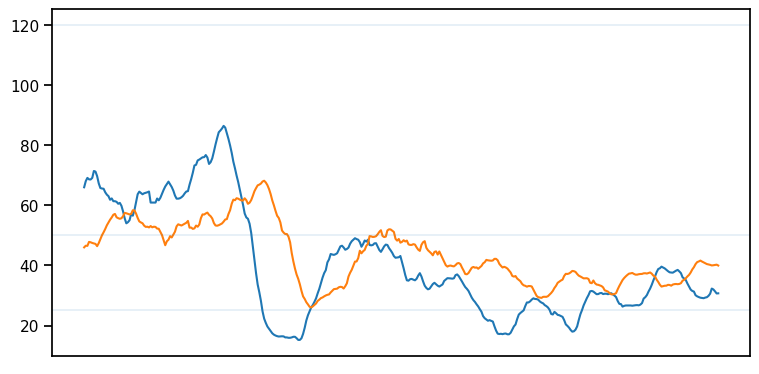

In [72]:
plt.figure(figsize=(9,4.5))
plt.plot(test_24[-392:])
plt.axhline(y=120,linewidth=.15)
plt.axhline(y=50,linewidth=.15)
plt.axhline(y=25,linewidth=.15)
plt.xticks(ticks=[])
plt.show()

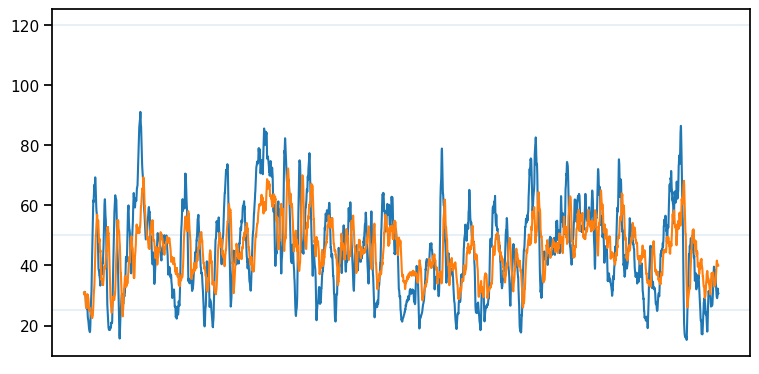

In [71]:
plt.figure(figsize=(9,4.5))
plt.plot(test_24)
plt.axhline(y=120,linewidth=.15)
plt.axhline(y=50,linewidth=.15)
plt.axhline(y=25,linewidth=.15)
plt.xticks(ticks=[])
plt.show()

In [22]:
step_fit_00 = auto_arima(NO2_24_00[1:],trace=True,suppress_warnings=True)
step_fit_01 = auto_arima(NO2_24_01[1:],trace=True,suppress_warnings=True)
step_fit_02 = auto_arima(NO2_24_02[1:],trace=True,suppress_warnings=True)
step_fit_03 = auto_arima(NO2_24_03[1:],trace=True,suppress_warnings=True)
step_fit_04 = auto_arima(NO2_24_04[1:],trace=True,suppress_warnings=True)
step_fit_05 = auto_arima(NO2_24_05[1:],trace=True,suppress_warnings=True)
step_fit_06 = auto_arima(NO2_24_06[1:],trace=True,suppress_warnings=True)
step_fit_07 = auto_arima(NO2_24_07[1:],trace=True,suppress_warnings=True)
step_fit_08 = auto_arima(NO2_24_08[1:],trace=True,suppress_warnings=True)
step_fit_09 = auto_arima(NO2_24_09[1:],trace=True,suppress_warnings=True)
step_fit_10 = auto_arima(NO2_24_10[1:],trace=True,suppress_warnings=True)
step_fit_11 = auto_arima(NO2_24_11[1:],trace=True,suppress_warnings=True)
step_fit_12 = auto_arima(NO2_24_12[1:],trace=True,suppress_warnings=True)
step_fit_13 = auto_arima(NO2_24_13[1:],trace=True,suppress_warnings=True)
step_fit_14 = auto_arima(NO2_24_14[1:],trace=True,suppress_warnings=True)
step_fit_15 = auto_arima(NO2_24_15[1:],trace=True,suppress_warnings=True)
step_fit_16 = auto_arima(NO2_24_16[1:],trace=True,suppress_warnings=True)
step_fit_17 = auto_arima(NO2_24_17[1:],trace=True,suppress_warnings=True)
step_fit_18 = auto_arima(NO2_24_18[1:],trace=True,suppress_warnings=True)
step_fit_19 = auto_arima(NO2_24_19[1:],trace=True,suppress_warnings=True)
step_fit_20 = auto_arima(NO2_24_20[1:],trace=True,suppress_warnings=True)
step_fit_21 = auto_arima(NO2_24_21[1:],trace=True,suppress_warnings=True)
step_fit_22 = auto_arima(NO2_24_22[1:],trace=True,suppress_warnings=True)
step_fit_23 = auto_arima(NO2_24_23[1:],trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6498.541, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6712.807, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6678.303, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6626.520, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6710.815, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6496.615, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6507.510, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6501.090, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6498.529, Time=0.80 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6497.909, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6497.198, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6500.024, Time=1.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6494.657, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6505.551, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]          

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6530.703, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6533.890, Time=1.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6528.707, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6539.594, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6533.282, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6531.540, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=6530.695, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6664.045, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=6529.605, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6528.723, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=6531.911, Time=0.70 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 8.515 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6536.505, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6756.788, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6555.142, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6595.311, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6404.401, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6411.483, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6544.093, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6404.708, Time=0.55 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6507.085, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6406.175, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6402.428, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6409.510, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6542.098, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6402.734, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6403.218, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6574.990, Time=0.03 sec
 ARIMA(1,1,2)(0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6452.840, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6447.018, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6453.875, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6578.134, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6449.013, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6449.005, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6625.025, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6447.266, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=6555.838, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=6450.876, Time=0.45 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 7.143 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6463.045, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6665.987, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6641.236, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=1.01 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 7.966 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6497.654, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6710.621, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6676.027, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6625.601, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6708.629, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6495.690, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6507.449, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6499.735, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6497.652, Time=0.69 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6497.049, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6496.096, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,1,2)(0,0,0)[0]         

In [23]:
print(step_fit_00.summary())
print(step_fit_01.summary())
print(step_fit_02.summary())
print(step_fit_03.summary())
print(step_fit_04.summary())
print(step_fit_05.summary())
print(step_fit_06.summary())
print(step_fit_07.summary())
print(step_fit_08.summary())
print(step_fit_09.summary())
print(step_fit_10.summary())
print(step_fit_11.summary())
print(step_fit_12.summary())
print(step_fit_13.summary())
print(step_fit_14.summary())
print(step_fit_15.summary())
print(step_fit_16.summary())
print(step_fit_17.summary())
print(step_fit_18.summary())
print(step_fit_19.summary())
print(step_fit_20.summary())
print(step_fit_21.summary())
print(step_fit_22.summary())
print(step_fit_23.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  862
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -3243.328
Date:                Mon, 11 Jul 2022   AIC                           6494.657
Time:                        09:55:17   BIC                           6513.689
Sample:                             0   HQIC                          6501.943
                                - 862                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3050      0.075      4.043      0.000       0.157       0.453
ma.L1         -0.7367      0.076     -9.693      0.000      -0.886      -0.588
ma.L2         -0.1858      0.066     -2.827      0.0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  862
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -3213.201
Date:                Mon, 11 Jul 2022   AIC                           6434.403
Time:                        09:55:17   BIC                           6453.435
Sample:                             0   HQIC                          6441.689
                                - 862                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5531      0.034     16.064      0.000       0.486       0.621
ar.L2         -0.1061      0.034     -3.079      0.002      -0.174      -0.039
ma.L1         -0.9372      0.015    -62.757      0.0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  862
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -3244.546
Date:                Mon, 11 Jul 2022   AIC                           6497.092
Time:                        09:55:17   BIC                           6516.125
Sample:                             0   HQIC                          6504.378
                                - 862                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3160      0.076      4.147      0.000       0.167       0.465
ma.L1         -0.7520      0.077     -9.821      0.000      -0.902      -0.602
ma.L2         -0.1721      0.066     -2.602      0.0

In [28]:
step_fit_00=ARIMA(NO2_24_00[1:],order=(0,1,3)).fit()
step_fit_01=ARIMA(NO2_24_01[1:],order=(0,1,3)).fit()
step_fit_02=ARIMA(NO2_24_02[1:],order=(0,1,3)).fit()
step_fit_03=ARIMA(NO2_24_03[1:],order=(0,1,3)).fit()
step_fit_04=ARIMA(NO2_24_04[1:],order=(0,1,3)).fit()
step_fit_05=ARIMA(NO2_24_05[1:],order=(0,1,3)).fit()
step_fit_06=ARIMA(NO2_24_05[1:],order=(0,1,3)).fit()
step_fit_07=ARIMA(NO2_24_07[1:],order=(0,1,3)).fit()
step_fit_08=ARIMA(NO2_24_08[1:],order=(0,1,3)).fit()
step_fit_09=ARIMA(NO2_24_09[1:],order=(0,1,3)).fit()
step_fit_10=ARIMA(NO2_24_10[1:],order=(0,1,3)).fit()
step_fit_11=ARIMA(NO2_24_11[1:],order=(0,1,3)).fit()
step_fit_12=ARIMA(NO2_24_12[1:],order=(0,1,3)).fit()
step_fit_13=ARIMA(NO2_24_13[1:],order=(0,1,3)).fit()
step_fit_14=ARIMA(NO2_24_14[1:],order=(0,1,3)).fit()
step_fit_15=ARIMA(NO2_24_15[1:],order=(0,1,3)).fit()
step_fit_16=ARIMA(NO2_24_16[1:],order=(0,1,3)).fit()
step_fit_17=ARIMA(NO2_24_17[1:],order=(0,1,3)).fit()
step_fit_18=ARIMA(NO2_24_18[1:],order=(0,1,3)).fit()
step_fit_19=ARIMA(NO2_24_19[1:],order=(0,1,3)).fit()
step_fit_20=ARIMA(NO2_24_20[1:],order=(0,1,3)).fit()
step_fit_21=ARIMA(NO2_24_21[1:],order=(0,1,3)).fit()
step_fit_22=ARIMA(NO2_24_22[1:],order=(0,1,3)).fit()
step_fit_23=ARIMA(NO2_24_23[1:],order=(0,1,3)).fit()

In [29]:
print(step_fit_00.summary())
print(step_fit_01.summary())
print(step_fit_02.summary())
print(step_fit_03.summary())
print(step_fit_04.summary())
print(step_fit_05.summary())
print(step_fit_06.summary())
print(step_fit_07.summary())
print(step_fit_08.summary())
print(step_fit_09.summary())
print(step_fit_10.summary())
print(step_fit_11.summary())
print(step_fit_12.summary())
print(step_fit_13.summary())
print(step_fit_14.summary())
print(step_fit_15.summary())
print(step_fit_16.summary())
print(step_fit_17.summary())
print(step_fit_18.summary())
print(step_fit_19.summary())
print(step_fit_20.summary())
print(step_fit_21.summary())
print(step_fit_22.summary())
print(step_fit_23.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -3243.955
Method:                       css-mle   S.D. of innovations             10.464
Date:                Mon, 11 Jul 2022   AIC                           6497.910
Time:                        10:07:21   BIC                           6521.701
Sample:                             1   HQIC                          6507.017
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0087      0.043     -0.205      0.838      -0.092       0.075
ma.L1.D.mg/m^3_im_24h    -0.4332      0.034    -12.762      0.000      -0.500      -0.367
ma.L2.D.

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -3255.693
Method:                       css-mle   S.D. of innovations             10.608
Date:                Mon, 11 Jul 2022   AIC                           6521.387
Time:                        10:07:22   BIC                           6545.177
Sample:                             1   HQIC                          6530.494
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0061      0.041     -0.148      0.882      -0.087       0.075
ma.L1.D.mg/m^3_im_24h    -0.4314      0.034    -12.748      0.000      -0.498      -0.365
ma.L2.D.

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -3199.125
Method:                       css-mle   S.D. of innovations              9.933
Date:                Mon, 11 Jul 2022   AIC                           6408.249
Time:                        10:07:22   BIC                           6432.040
Sample:                             1   HQIC                          6417.356
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0072      0.041     -0.176      0.860      -0.088       0.073
ma.L1.D.mg/m^3_im_24h    -0.3744      0.033    -11.221      0.000      -0.440      -0.309
ma.L2.D.

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -3234.818
Method:                       css-mle   S.D. of innovations             10.354
Date:                Mon, 11 Jul 2022   AIC                           6479.637
Time:                        10:07:23   BIC                           6503.427
Sample:                             1   HQIC                          6488.744
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0085      0.043     -0.200      0.842      -0.092       0.075
ma.L1.D.mg/m^3_im_24h    -0.4148      0.034    -12.329      0.000      -0.481      -0.349
ma.L2.D.

In [30]:
step_fit_00=ARIMA(NO2_24_00[1:],order=(1,1,2)).fit()
step_fit_01=ARIMA(NO2_24_01[1:],order=(1,1,2)).fit()
step_fit_02=ARIMA(NO2_24_02[1:],order=(1,1,2)).fit()
step_fit_03=ARIMA(NO2_24_03[1:],order=(1,1,2)).fit()
step_fit_04=ARIMA(NO2_24_04[1:],order=(1,1,2)).fit()
step_fit_05=ARIMA(NO2_24_05[1:],order=(1,1,2)).fit()
step_fit_06=ARIMA(NO2_24_05[1:],order=(1,1,2)).fit()
step_fit_07=ARIMA(NO2_24_07[1:],order=(1,1,2)).fit()
step_fit_08=ARIMA(NO2_24_08[1:],order=(1,1,2)).fit()
step_fit_09=ARIMA(NO2_24_09[1:],order=(1,1,2)).fit()
step_fit_10=ARIMA(NO2_24_10[1:],order=(1,1,2)).fit()
step_fit_11=ARIMA(NO2_24_11[1:],order=(1,1,2)).fit()
step_fit_12=ARIMA(NO2_24_12[1:],order=(1,1,2)).fit()
step_fit_13=ARIMA(NO2_24_13[1:],order=(1,1,2)).fit()
step_fit_14=ARIMA(NO2_24_14[1:],order=(1,1,2)).fit()
step_fit_15=ARIMA(NO2_24_15[1:],order=(1,1,2)).fit()
step_fit_16=ARIMA(NO2_24_16[1:],order=(1,1,2)).fit()
step_fit_17=ARIMA(NO2_24_17[1:],order=(1,1,2)).fit()
step_fit_18=ARIMA(NO2_24_18[1:],order=(1,1,2)).fit()
step_fit_19=ARIMA(NO2_24_19[1:],order=(1,1,2)).fit()
step_fit_20=ARIMA(NO2_24_20[1:],order=(1,1,2)).fit()
step_fit_21=ARIMA(NO2_24_21[1:],order=(1,1,2)).fit()
step_fit_22=ARIMA(NO2_24_22[1:],order=(1,1,2)).fit()
step_fit_23=ARIMA(NO2_24_23[1:],order=(1,1,2)).fit()

In [31]:
print(step_fit_00.summary())
print(step_fit_01.summary())
print(step_fit_02.summary())
print(step_fit_03.summary())
print(step_fit_04.summary())
print(step_fit_05.summary())
print(step_fit_06.summary())
print(step_fit_07.summary())
print(step_fit_08.summary())
print(step_fit_09.summary())
print(step_fit_10.summary())
print(step_fit_11.summary())
print(step_fit_12.summary())
print(step_fit_13.summary())
print(step_fit_14.summary())
print(step_fit_15.summary())
print(step_fit_16.summary())
print(step_fit_17.summary())
print(step_fit_18.summary())
print(step_fit_19.summary())
print(step_fit_20.summary())
print(step_fit_21.summary())
print(step_fit_22.summary())
print(step_fit_23.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3243.308
Method:                       css-mle   S.D. of innovations             10.456
Date:                Mon, 11 Jul 2022   AIC                           6496.616
Time:                        10:12:39   BIC                           6520.406
Sample:                             1   HQIC                          6505.723
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0082      0.040     -0.204      0.838      -0.087       0.071
ar.L1.D.mg/m^3_im_24h     0.3050      0.079      3.852      0.000       0.150       0.460
ma.L1.D.

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3260.343
Method:                       css-mle   S.D. of innovations             10.665
Date:                Mon, 11 Jul 2022   AIC                           6530.687
Time:                        10:12:40   BIC                           6554.477
Sample:                             1   HQIC                          6539.794
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0057      0.040     -0.143      0.886      -0.084       0.072
ar.L1.D.mg/m^3_im_24h     0.3027      0.078      3.890      0.000       0.150       0.455
ma.L1.D.

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3197.331
Method:                       css-mle   S.D. of innovations              9.913
Date:                Mon, 11 Jul 2022   AIC                           6404.663
Time:                        10:12:41   BIC                           6428.453
Sample:                             1   HQIC                          6413.770
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0065      0.038     -0.171      0.864      -0.081       0.068
ar.L1.D.mg/m^3_im_24h     0.3955      0.062      6.338      0.000       0.273       0.518
ma.L1.D.

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3225.524
Method:                       css-mle   S.D. of innovations             10.243
Date:                Mon, 11 Jul 2022   AIC                           6461.047
Time:                        10:12:42   BIC                           6484.838
Sample:                             1   HQIC                          6470.155
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0076      0.039     -0.193      0.847      -0.085       0.070
ar.L1.D.mg/m^3_im_24h     0.3284      0.073      4.505      0.000       0.186       0.471
ma.L1.D.

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3242.846
Method:                       css-mle   S.D. of innovations             10.451
Date:                Mon, 11 Jul 2022   AIC                           6495.691
Time:                        10:12:42   BIC                           6519.482
Sample:                             1   HQIC                          6504.799
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0081      0.040     -0.201      0.841      -0.087       0.071
ar.L1.D.mg/m^3_im_24h     0.3149      0.078      4.014      0.000       0.161       0.469
ma.L1.D.

In [34]:
step_fit_00=ARIMA(NO2_24_00[1:],order=(2,1,1)).fit()
step_fit_01=ARIMA(NO2_24_01[1:],order=(2,1,1)).fit()
step_fit_02=ARIMA(NO2_24_02[1:],order=(2,1,1)).fit()
step_fit_03=ARIMA(NO2_24_03[1:],order=(2,1,1)).fit()
step_fit_04=ARIMA(NO2_24_04[1:],order=(2,1,1)).fit()
step_fit_05=ARIMA(NO2_24_05[1:],order=(2,1,1)).fit()
step_fit_06=ARIMA(NO2_24_05[1:],order=(2,1,1)).fit()
step_fit_07=ARIMA(NO2_24_07[1:],order=(2,1,1)).fit()
step_fit_08=ARIMA(NO2_24_08[1:],order=(2,1,1)).fit()
step_fit_09=ARIMA(NO2_24_09[1:],order=(2,1,1)).fit()
step_fit_10=ARIMA(NO2_24_10[1:],order=(2,1,1)).fit()
step_fit_11=ARIMA(NO2_24_11[1:],order=(2,1,1)).fit()
step_fit_12=ARIMA(NO2_24_12[1:],order=(2,1,1)).fit()
step_fit_13=ARIMA(NO2_24_13[1:],order=(2,1,1)).fit()
step_fit_14=ARIMA(NO2_24_14[1:],order=(2,1,1)).fit()
step_fit_15=ARIMA(NO2_24_15[1:],order=(2,1,1)).fit()
step_fit_16=ARIMA(NO2_24_16[1:],order=(2,1,1)).fit()
step_fit_17=ARIMA(NO2_24_17[1:],order=(2,1,1)).fit()
step_fit_18=ARIMA(NO2_24_18[1:],order=(2,1,1)).fit()
step_fit_19=ARIMA(NO2_24_19[1:],order=(2,1,1)).fit()
step_fit_20=ARIMA(NO2_24_20[1:],order=(2,1,1)).fit()
step_fit_21=ARIMA(NO2_24_21[1:],order=(2,1,1)).fit()
step_fit_22=ARIMA(NO2_24_22[1:],order=(2,1,1)).fit()
step_fit_23=ARIMA(NO2_24_23[1:],order=(2,1,1)).fit()

In [35]:
print(step_fit_00.summary())
print(step_fit_01.summary())
print(step_fit_02.summary())
print(step_fit_03.summary())
print(step_fit_04.summary())
print(step_fit_05.summary())
print(step_fit_06.summary())
print(step_fit_07.summary())
print(step_fit_08.summary())
print(step_fit_09.summary())
print(step_fit_10.summary())
print(step_fit_11.summary())
print(step_fit_12.summary())
print(step_fit_13.summary())
print(step_fit_14.summary())
print(step_fit_15.summary())
print(step_fit_16.summary())
print(step_fit_17.summary())
print(step_fit_18.summary())
print(step_fit_19.summary())
print(step_fit_20.summary())
print(step_fit_21.summary())
print(step_fit_22.summary())
print(step_fit_23.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3243.600
Method:                       css-mle   S.D. of innovations             10.460
Date:                Mon, 11 Jul 2022   AIC                           6497.199
Time:                        10:17:11   BIC                           6520.990
Sample:                             1   HQIC                          6506.307
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0083      0.041     -0.204      0.839      -0.088       0.072
ar.L1.D.mg/m^3_im_24h     0.4988      0.037     13.474      0.000       0.426       0.571
ar.L2.D.

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3260.352
Method:                       css-mle   S.D. of innovations             10.665
Date:                Mon, 11 Jul 2022   AIC                           6530.703
Time:                        10:17:12   BIC                           6554.493
Sample:                             1   HQIC                          6539.810
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0058      0.040     -0.143      0.887      -0.085       0.073
ar.L1.D.mg/m^3_im_24h     0.4942      0.037     13.440      0.000       0.422       0.566
ar.L2.D.

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3197.201
Method:                       css-mle   S.D. of innovations              9.911
Date:                Mon, 11 Jul 2022   AIC                           6404.401
Time:                        10:17:13   BIC                           6428.192
Sample:                             1   HQIC                          6413.509
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0064      0.040     -0.163      0.871      -0.084       0.071
ar.L1.D.mg/m^3_im_24h     0.5662      0.037     15.497      0.000       0.495       0.638
ar.L2.D.

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3225.646
Method:                       css-mle   S.D. of innovations             10.244
Date:                Mon, 11 Jul 2022   AIC                           6461.292
Time:                        10:17:14   BIC                           6485.083
Sample:                             1   HQIC                          6470.400
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0077      0.040     -0.192      0.848      -0.087       0.071
ar.L1.D.mg/m^3_im_24h     0.5377      0.037     14.637      0.000       0.466       0.610
ar.L2.D.

                             ARIMA Model Results                              
Dep. Variable:        D.mg/m^3_im_24h   No. Observations:                  861
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3243.049
Method:                       css-mle   S.D. of innovations             10.453
Date:                Mon, 11 Jul 2022   AIC                           6496.097
Time:                        10:17:14   BIC                           6519.888
Sample:                             1   HQIC                          6505.205
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0081      0.041     -0.200      0.841      -0.088       0.071
ar.L1.D.mg/m^3_im_24h     0.5005      0.037     13.528      0.000       0.428       0.573
ar.L2.D.

# 1y mean analysis

In [15]:
NO2["mg/m^3_im_1y"] = np.nan

for j in range(8759, len(NO2)):

    NO2[ "mg/m^3_im_1y"][j] = NO2["mg/m^3_im"][j-8759:j+1].mean()
    
NO2

,mg/m^3,mg/m^3_im,mg/m^3_im_1y
DATETIME,,,
2019-07-01 01:00:00,33.0,33.0,NaN
2019-07-01 02:00:00,27.0,27.0,NaN
2019-07-01 03:00:00,25.0,25.0,NaN
2019-07-01 04:00:00,34.0,34.0,NaN
2019-07-01 05:00:00,21.0,21.0,NaN
...,...,...,...
2022-06-30 20:00:00,76.0,76.0,42.547649
2022-06-30 21:00:00,30.0,30.0,42.546393
2022-06-30 22:00:00,20.0,20.0,42.546393


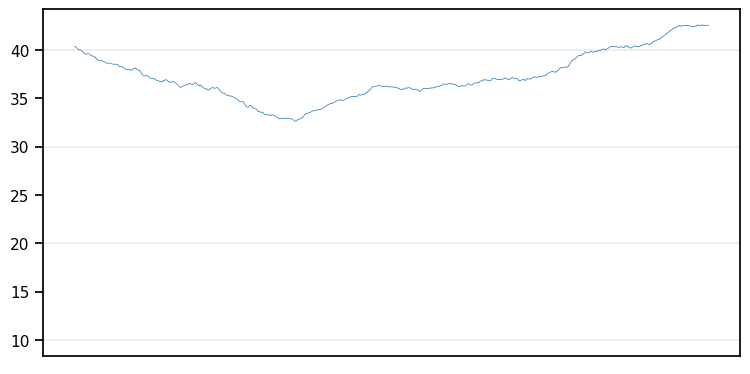

In [18]:
#plt.figure(figsize=(9,4.5))
#sns.set_context("notebook")
#sns.axes_style("whitegrid")
#graph = sns.lineplot(data=NO2["mg/m^3_im_1y"])

#graph.axhline(10,linewidth=.3)
#graph.axhline(20,linewidth=.3)
#graph.axhline(30,linewidth=.3)
#graph.axhline(40,linewidth=.3)

plt.figure(figsize=(9,4.5))
#sns.set_context("notebook")
#sns.axes_style("whitegrid")
#graph = sns.lineplot(data=NO2["mg/m^3_43_24h"],linewidth=.1)

plt.plot(NO2["mg/m^3_im_1y"],linewidth=.5)

#plt.gcf().autofmt_xdate()
plt.axhline(y=10,linewidth=.15)
plt.axhline(y=20,linewidth=.15)
plt.axhline(y=30,linewidth=.15)
plt.axhline(y=40,linewidth=.15)
plt.xticks(ticks=[])
#ax=plt.axes()
#ax.set_facecolor('white')

plt.show()


#plt.show()

In [37]:
NO2[NO2["mg/m^3_im_1y"]<40]["mg/m^3_im_1y"]

DATETIME
2020-07-16 03:00:00    39.999079
2020-07-16 04:00:00    39.997595
2020-07-16 05:00:00    39.995768
2020-07-16 06:00:00    39.991431
2020-07-16 07:00:00    39.989490
                         ...    
2022-03-01 20:00:00    39.998541
2022-03-07 05:00:00    39.998418
2022-03-07 06:00:00    39.996250
2022-03-07 07:00:00    39.995679
2022-03-07 08:00:00    39.998647
Name: mg/m^3_im_1y, Length: 14062, dtype: float64

In [39]:
NO2[NO2["mg/m^3_im_1y"]==NO2["mg/m^3_im_1y"].min()]["mg/m^3_im_1y"]

DATETIME
2021-03-21 17:00:00    32.630538
Name: mg/m^3_im_1y, dtype: float64

## ARIMA forecasting

In [22]:
size = int(len(NO2["mg/m^3_im"])*.8)

train, test = NO2["mg/m^3_im"].iloc[:size], NO2["mg/m^3_im"].iloc[size:]
train.to_csv("NO2_E43_train.csv")
test.to_csv("NO2_E43_test.csv")

In [23]:
step_fit = auto_arima(train,trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=156780.209, Time=33.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=159018.775, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=159009.862, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=159007.930, Time=2.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=159016.775, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=31.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=156856.224, Time=12.83 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=156782.367, Time=32.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=156782.321, Time=29.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=13.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=156830.269, Time=15.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=156799.360, Time=18.77 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=156783.295, Time=29.41 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=156778.209, Time=8.18 sec
 ARIMA(1,1

In [24]:
step_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                20716
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -78384.104
Date:                Thu, 07 Jul 2022   AIC                         156778.209
Time:                        10:42:57   BIC                         156817.902
Sample:                             0   HQIC                        156791.173
                              - 20716                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3101      0.029     45.032      0.000       1.253       1.367
ar.L2         -0.4803      0.023    -21.117      0.000      -0.525      -0.436
ma.L1         -1.3893      0.031    -45.036      0.000      -1.450      -1.329
ma.L2          0.4172      0.030     13.956      0.000       0.359       0.476
sigma2       113.2870      0.722    156.837      0.000     111.871     114.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9208.86
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model = ARIMA(train,order=(1,1,5))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.mg/m^3_im   No. Observations:                20715
Model:                 ARIMA(1, 1, 5)   Log Likelihood              -78393.940
Method:                       css-mle   S.D. of innovations             10.649
Date:                Thu, 07 Jul 2022   AIC                         156803.881
Time:                        21:39:45   BIC                         156867.389
Sample:                             1   HQIC                        156824.623
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0001      0.010      0.011      0.991      -0.020       0.020
ar.L1.D.mg/m^3_im     0.5809      0.025     23.253      0.000       0.532       0.630
ma.L1.D.mg/m^3_im    -0.6602      0.026    -25.878      0.000      -0.710      -0.610
ma.L2.D.mg/m^3_im    -0.1242      0.009    -14.325      0.000      -0.141      -0.107
ma.L3.D.mg/m^3_im    -0.0815      0.010     -8.316      0.000      -0.101      -0.062
ma.L4.D.mg/m^3_im    -0.0452      0.010     -4.635      0.000      -0.064      -0.026
ma.L5.D.mg/m^3_im    -0.0309      0.010     -3.091      0.002      -0.050      -0.011
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7215           +0.0000j            1.7215            0.0000
MA.1            1.0380           -0.0000j            1.0380           -0.0000
MA.2            0.7554           -2.0575j            2.1918           -0.1940
MA.3            0.7554           +2.0575j            2.1918            0.1940
MA.4           -2.0066           -1.5720j            2.5490           -0.3942
MA.5           -2.0066           +1.5720j            2.5490            0.3942
-----------------------------------------------------------------------------
"""

In [25]:
model = ARIMA(train,order=(2,1,2))
model = model.fit(method='mle')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.mg/m^3_im   No. Observations:                20715
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -78384.105
Method:                           mle   S.D. of innovations             10.644
Date:                Thu, 07 Jul 2022   AIC                         156780.209
Time:                        10:43:48   BIC                         156827.841
Sample:                             1   HQIC                        156795.766
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0001      0.012      0.011      0.991      -0.024       0.024
ar.L1.D.mg/m^3_im     1.3102      0.034     38.869      0.000       1.244       1.376
ar.L2.D.mg/m^3_im    -0.4804      0.027    -17.800      0.000      -0.533      -0.428
ma.L1.D.mg/m^3_im    -1.3894      0.036    -38.885      0.000      -1.459      -1.319
ma.L2.D.mg/m^3_im     0.4173      0.035     11.825      0.000       0.348       0.486
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3636           -0.4712j            1.4428           -0.0530
AR.2            1.3636           +0.4712j            1.4428            0.0530
MA.1            1.0523           +0.0000j            1.0523            0.0000
MA.2            2.2772           +0.0000j            2.2772            0.0000
-----------------------------------------------------------------------------
"""

In [33]:
forecast= model.forecast(steps = int(len(NO2["mg/m^3_im"])*.2))

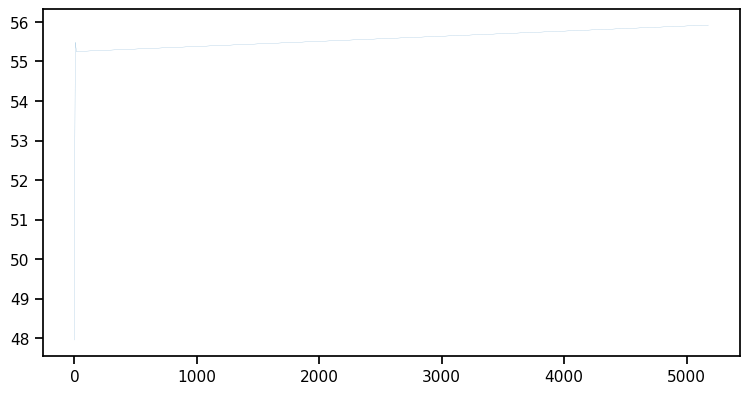

In [35]:
plt.figure(figsize=(9,4.5))



plt.plot(forecast[0], linewidth=.1)
plt.show()

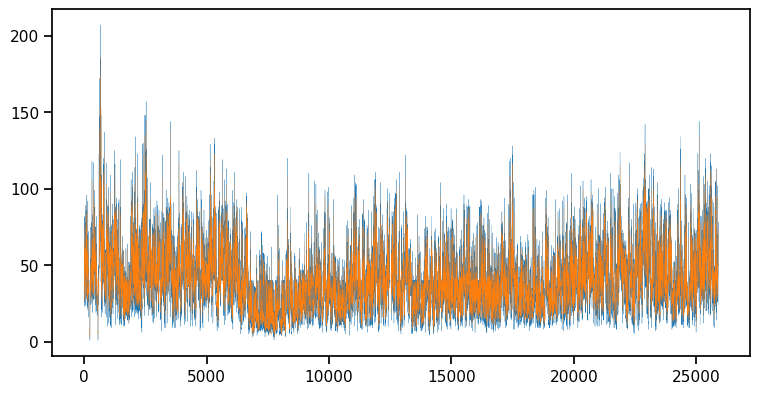

In [21]:
pred=model.predict(typ='levels')
plt.figure(figsize=(9,4.5))


plt.plot(NO2["mg/m^3_im"], linewidth =.2)
plt.plot(pred, linewidth=.1)
plt.show()

In [22]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape(pred,NO2["mg/m^3_im"][2:])

21.67271008298351

In [14]:
test_forecast =pd.read_csv("testforecast.csv")

In [15]:
test_forecast

,Unnamed: 0,x
0,1,31.968000
1,2,32.739564
2,3,47.931690
3,4,76.462322
4,5,68.849577
...,...,...
5175,5176,68.550642
5176,5177,73.376242
5177,5178,71.232568
5178,5179,39.675703


In [32]:
testvsforecast=pd.DataFrame(list(zip(list(test),list(test_forecast["x"]))),columns=["test","forecast"])
testvsforecast

,test,forecast
0,32.0,31.968000
1,46.0,32.739564
2,77.0,47.931690
3,72.0,76.462322
4,84.0,68.849577
...,...,...
5175,78.0,68.550642
5176,77.0,73.376242
5177,43.0,71.232568
5178,32.0,39.675703


In [33]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape(testvsforecast["test"],testvsforecast["forecast"])

22.36706900766858

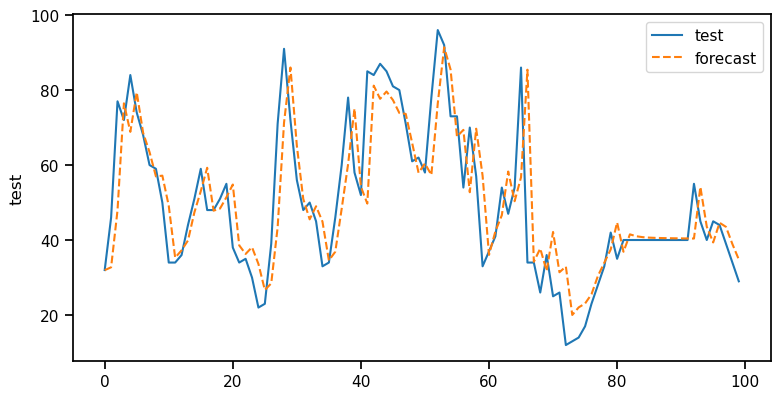

In [39]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=testvsforecast["test"][:100], label="test")
sns.lineplot(data=testvsforecast["forecast"][:100], label ="forecast", linestyle='--')

plt.show()